# Random Forests

TODO:
- talk about decision trees and random forests, compare random forests to decision trees (ensemble, bagging, etc.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv("../data/thorax_and_wing_mdi_train.csv")
test = pd.read_csv("../data/thorax_and_wing_mdi_test.csv")

predictors = [c for c in train.columns if c != "Species"]

X_train, y_train = train[predictors].to_numpy(), train["Species"].to_numpy()
X_test, y_test = test[predictors].to_numpy(), test["Species"].to_numpy()

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)

Train dataset: (1211, 14) (1211,)
Test dataset: (519, 14) (519,)


## Hyperparameter Selection

There are two important hyperparameters for a random forest that we consider - the number of trees in the forest, and the maximum depth of each tree.

For the first, it can be shown that more ensemble members only reduces the model variance* but does not increase the model flexibility. This means that a larger number of trees does not lead to overfitting, so the only reason for choosing a small number of trees would be due to computational cost.

For the second (maximum depth), we can use cross-validation to select the optimal value. By default in sklearn, the max depth is not limited and all leaves will be expanded until they're pure or only contain one node. This can lead to massive trees both in terms of size and complexity, which is likely to lead to overfitting, so the max depth should be controlled.

*the model variance is eventually limited by the average correlation between the trees, at which point it plateaus.

First we do grid search CV to find the optimal max depth:

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": range(1, 30)}

forest = RandomForestClassifier(n_estimators=100, random_state=42)
grid_search = GridSearchCV(forest, parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(1, 30)})

In [4]:
print("Best params       :", grid_search.best_params_)
print("Best mean CV score:", grid_search.best_score_)

Best params       : {'max_depth': 15}
Best mean CV score: 0.7861272659252457


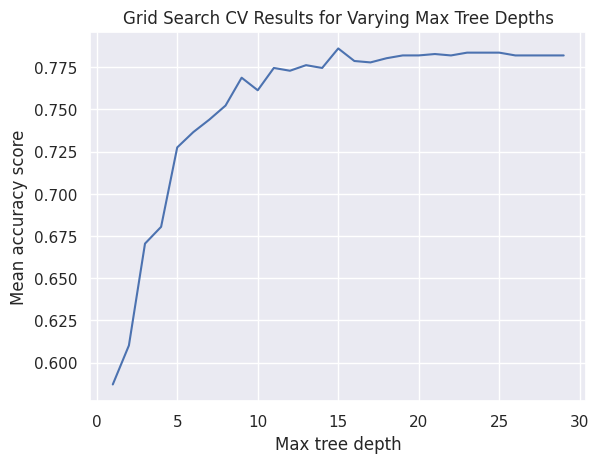

In [6]:
scores = grid_search.cv_results_["mean_test_score"]
depths = grid_search.cv_results_["param_max_depth"].data

fig, ax = plt.subplots()
ax.plot(depths, scores)
ax.set_title("Grid Search CV Results for Varying Max Tree Depths")
ax.set_xlabel("Max tree depth")
ax.set_ylabel("Mean accuracy score")
plt.savefig("../fig/grid_search_cv_random_forest.png")
plt.show()

Next we choose the number of trees to put in the forest. For this we can estimate the model variance for varying ensemble sizes and see when the variance plateaus. We can pick the size at which the variance plateaus - there is no benefit to picking a size larger than this.

In [7]:
def estimate_variance(X, y, clf, num_parts=10, **kwargs):
    # Split X and y into num_parts parts (truncate if necessary)
    X = X[:(X.shape[0] // num_parts) * num_parts]
    y = y[:(y.shape[0] // num_parts) * num_parts]
    X_parts = np.split(X, num_parts)
    y_parts = np.split(y, num_parts)

    holdout_vars = []
    for i in range(num_parts):
        # Extract the ith part as holdout set
        X_holdout, y_holdout = X_parts[i], y_parts[i]

        # Extract all other parts as training set
        X_train = np.concatenate(X_parts[:i] + X_parts[i+1:])
        y_train = np.concatenate(y_parts[:i] + y_parts[i+1:])

        # Fit decision tree classifier on training set
        tree = clf(random_state=42, **kwargs)
        tree.fit(X_train, y_train)

        # Use prediction probabilities to estimate variance
        holdout_pred = tree.predict_proba(X_holdout)[:, 1]
        holdout_var = np.var(holdout_pred)
        holdout_vars.append(holdout_var)

    # Calculate average variance across each trained model
    E_holdout_var = np.mean(holdout_vars)
    return E_holdout_var

In [8]:
holdout_vars = []
n_estimators_range = np.insert(np.arange(4, 129, 4), 0, 1)
for n_estimators in n_estimators_range:
    var = estimate_variance(X_train, y_train, RandomForestClassifier, n_estimators=n_estimators, max_depth=15)
    holdout_vars.append(var)

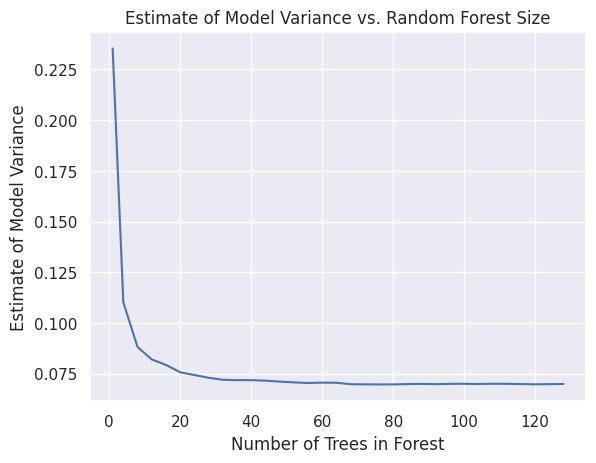

In [11]:
fig, ax = plt.subplots()

ax.plot(n_estimators_range, holdout_vars)
ax.set_title("Estimate of Model Variance vs. Random Forest Size")
ax.set_xlabel("Number of Trees in Forest")
ax.set_ylabel("Estimate of Model Variance")
plt.savefig("../fig/model_variance_random_forest.png")
plt.show()

The model variance plateaus at around 40 trees, so we will use 40 as the random forest size in the final classifier:

In [13]:
from sklearn.metrics import accuracy_score

forests = []
test_preds = []
for max_depth in (5, 15):
    forest = RandomForestClassifier(n_estimators=40, max_depth=max_depth, random_state=42)
    forest.fit(X_train, y_train)
    forests.append(forest)
    train_pred = forest.predict(X_train)
    test_pred = forest.predict(X_test)
    test_preds.append(test_pred)
    print("max_depth        :", max_depth)
    print("Training accuracy:", round(accuracy_score(y_train, train_pred), 3))
    print("Test accuracy    :", round(accuracy_score(y_test, test_pred), 3))

max_depth        : 5
Training accuracy: 0.822
Test accuracy    : 0.709
max_depth        : 15
Training accuracy: 0.998
Test accuracy    : 0.778


max_depth=5
max_depth=15


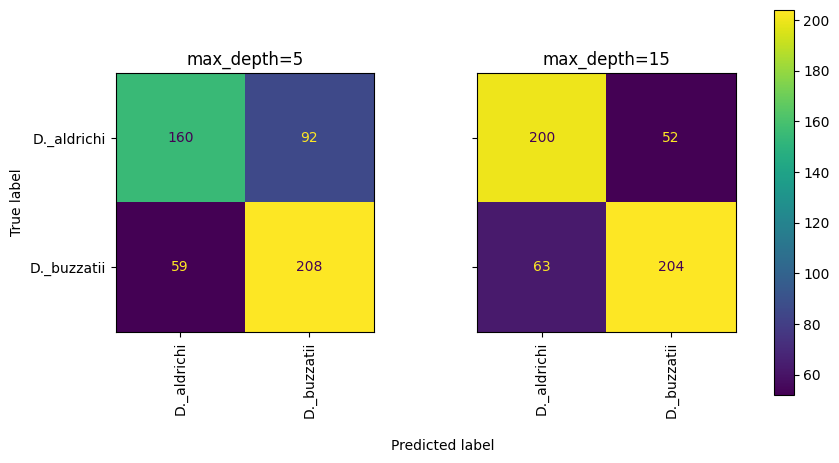

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib

matplotlib.rc_file_defaults()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
titles = ("max_depth=5", "max_depth=15")
for i, forest in enumerate(forests):
    print(titles[i])

    cm = confusion_matrix(y_test, test_preds[i], labels=forest.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
    disp.plot(ax=ax[i], xticks_rotation=90)
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("")
    if i != 0:
        disp.ax_.set_ylabel("")
plt.subplots_adjust(wspace=0.40, hspace=0.1)
fig.text(0.4, 0, 'Predicted label', ha='left')
fig.colorbar(disp.im_, ax=ax)
plt.savefig("../fig/cm_random_forest.png")
plt.show()